## Code Snippets for Data Preprocessing



In [39]:
# Imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Read the raw data
dfRaw = pd.read_csv('/Users/daniellemckenney/Programming/erasmusCourses/ML/mlProjectsBirbs/mlProjectBirds/dataset.csv', sep="\t", on_bad_lines="warn",parse_dates=['eventDate'])

In [4]:
# Print some useful stats: 
print(dfRaw.info())
print(dfRaw.describe())
print(dfRaw.shape)
print(dfRaw.columns)
# Number of unique locations
print(dfRaw['locality'].value_counts())
# All entries should be within Spain
print(dfRaw['countryCode'].value_counts())
# No data is missing in the relevant columns:
print(dfRaw.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753579 entries, 0 to 753578
Data columns (total 50 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   gbifID                            753579 non-null  int64         
 1   datasetKey                        753579 non-null  object        
 2   occurrenceID                      753579 non-null  object        
 3   kingdom                           753579 non-null  object        
 4   phylum                            753579 non-null  object        
 5   class                             753579 non-null  object        
 6   order                             753579 non-null  object        
 7   family                            753579 non-null  object        
 8   genus                             753579 non-null  object        
 9   species                           753579 non-null  object        
 10  infraspecificEpithet            

NameError: name 'df' is not defined

In [5]:
# Function Definitions
def cleanRawData(rawData, relevantColumns):
    # returns a dataframe with only the relevent columns and with invalid location entries removed
    df = rawData.filter(items=relevantColumns)
    df = df[(df['decimalLatitude'] != 0) & (df['decimalLongitude'] != 0)]
    return df

def fillInCounts0(data, dateCombination):
    # Fill in count=0 in the grouped summary
    # Get all unique combinations of the date combination
    existing_combinations = data[dateCombination].drop_duplicates()

    # Create a DataFrame with all unique species
    all_species_combinations = pd.DataFrame({'species': data['species'].unique()})

    # Cross join (cartesian product) to get all combinations of 'species', 'eventDate', and 'locality'
    all_combinations = pd.merge(existing_combinations.assign(key=1), all_species_combinations.assign(key=1), on='key').drop('key', axis=1)

    # Merge with the original DataFrame to get counts
    on = dateCombination.append('species')
    result_df = pd.merge(all_combinations, data, on=on, how='left').fillna(0)
    return result_df

In [114]:
relevantColumns = ['species','locality','decimalLatitude', 'decimalLongitude', 'eventDate']

df = cleanRawData(dfRaw, relevantColumns)

# Group by 'species', 'eventDate', and 'locality' and count the rows in each group
grouped_eventDate_df = df.groupby(['species', 'eventDate', 'locality']).size().reset_index(name='count')
# Fill in count=0 on days where a locality was visited but no entry was made for that species
grouped_eventDate_df = fillInCounts0(grouped_eventDate_df, ['eventDate', 'locality'])
# print(grouped_eventDate_df[10:])

grouped_eventDate_df['weekOfYear'] = grouped_eventDate_df['eventDate'].dt.isocalendar().week
grouped_eventDate_df['month'] = grouped_eventDate_df['eventDate'].dt.month
grouped_eventDate_df['quarter'] = grouped_eventDate_df['eventDate'].dt.to_period('Q')
grouped_eventDate_df['year'] = grouped_eventDate_df['eventDate'].dt.year

grouped_weekOfYear_df = grouped_eventDate_df.groupby(['species', 'weekOfYear', 'year', 'locality']).sum('count').reset_index()

grouped_month_df = grouped_eventDate_df.groupby(['species', 'month', 'year', 'locality']).sum('count').reset_index()

grouped_quarter_df = grouped_eventDate_df.groupby(['species', 'quarter', 'locality']).sum('count').reset_index()

grouped_year_df = grouped_eventDate_df.groupby(['species', 'year', 'locality']).sum('count').reset_index()

# print(grouped_weekOfYear_df[10:])
# print(grouped_month_df[10:])
# print(grouped_quarter_df[10:])
# print(grouped_year_df[10:])

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_8719/1018032544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locF['count'] = pd.to_numeric(locF['count'])


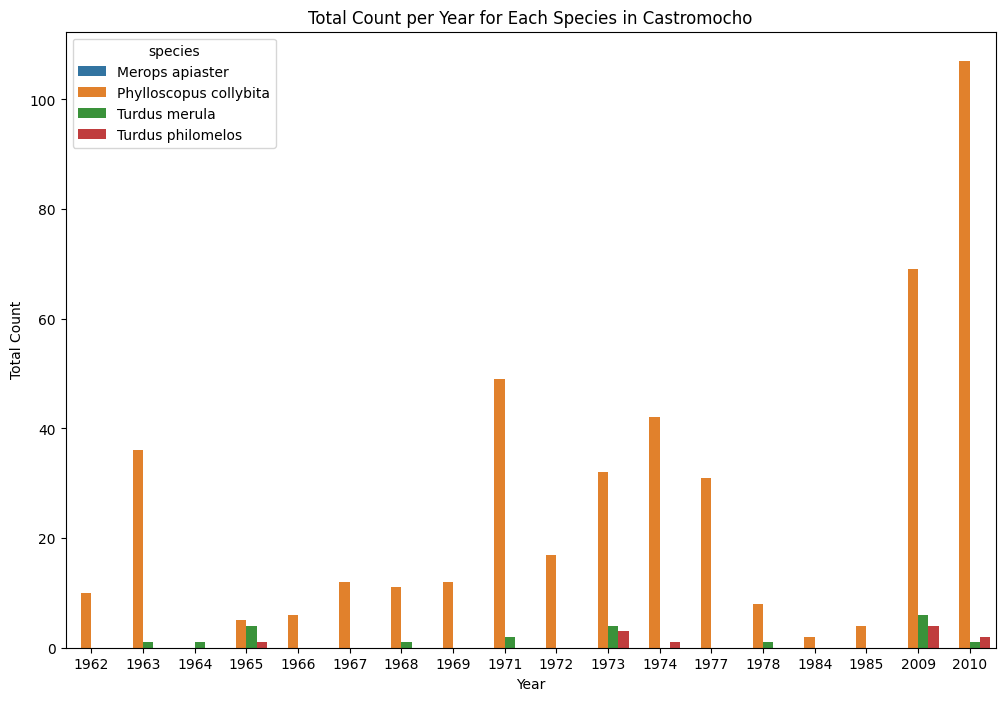

In [113]:

locF=  grouped_year_df[(grouped_year_df['locality'] =='Castromocho')]
locF['count'] = pd.to_numeric(locF['count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='year', y='count', hue='species', data=locF)
plt.title('Total Count per Year for Each Species in Castromocho')
plt.xlabel('Year')
plt.ylabel('Total Count')
plt.show()


In [30]:
# Explor the data grouped by week for chiff chaffs
chiffChaffWeek=  grouped_weekOfYear_df[(grouped_weekOfYear_df['species'] =='Phylloscopus collybita')]

canalVell =  chiffChaffWeek[(chiffChaffWeek['locality'] =="Canal vell")]

# View the locations where there are more than 600 entries
locals =chiffChaffWeek['locality'].value_counts()
filtered_locals = locals[locals > 600]
filtered_locals



locality
Canal vell                               1656
Traibuenas                               1410
Montiver                                 1364
Manecorro                                1002
Laguna de san juan                        972
Parque el alamillo                        898
P. NAT. EL HONDO                          872
Estanys jorda                             857
P. NAC. DEL ARCHIPIELAGO DE CABRERA       851
Las minas                                 807
Delta del llobregat                       785
Sebes                                     765
P. NAT. DESEMBOCADURA DEL GUADALHORCE     762
RIVAS-VACIAMADRID                         684
Name: count, dtype: int64

In [25]:
# Checking locality vs coordinates
# filtered_df = df[df['locality'].isin(['Localidad confidencial'])]
# print(filtered_df.filter(items=['locality', 'decimalLatitude','decimalLongitude', 'species', 'eventDate']))
# It looks like all of the coordinates of the same locality match

In [28]:
# Heatmap
gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(df['decimalLongitude'], df['decimalLatitude']),
                       crs='EPSG:4326')  # Assuming WGS 84 coordinate reference system

spain = gpd.read_file('/Users/daniellemckenney/Programming/erasmusCourses/ML/mlProjectsBirbs/mlProjectBirds/shapefile.shp')
species_spain = gpd.sjoin(gdf, spain, how='inner', op='within')
heatmap_data = species_spain.groupby(['species', 'NAME']).size().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(12, 8))
heatmap_data.plot(kind='bar', stacked=True, ax=ax)
plt.title('Species Distribution in Spain')
plt.xlabel('Species')
plt.ylabel('Frequency')
plt.show()



/Users/daniellemckenney/Programming/erasmusCourses/ML/mlProjectsBirbs/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_8719/3420082598.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  species_spain = gpd.sjoin(gdf, spain, how='inner', op='within')


KeyError: 'NAME'